### An implementation of an actor critic RL model

In [6]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
import gym

In [9]:
# DOES NOT USE EXPERIENCE REPLAY.
# I assume that it is bad for quantum. Remember to ask.
class ActorCritic():
  """A class encapsulating a hybrid actor critic network."""
  def __init__(self, actor_learning_rate,
               critic_learning_rate,
               regularisation,
               discount_factor, num_states,
               num_actions, network_dimensions,
               activation):
    self.gamma = discount_factor
    self.num_actions = num_actions
    self.memory = []
    self.actor, self.critic = self.create_model((actor_learning_rate, critic_learning_rate),
                                                regularisation,
                                                num_states, num_actions,
                                                network_dimensions, activation)

  def act(self, observation):
    return np.random.choice(self.num_actions,
                            p=self.actor.predict(observation[np.newaxis, :],
                                                 verbose=False).flatten())
  def save(self, timestamp):
      self.actor.save(f"actor_{timestamp}.keras")
      

  # Could use experience replay here.
  def learn(self, observation, action, reward, new_observation, done):
    self.memory.append((observation, action, reward, new_observation, done))

    if not done:
      return

    states, actions, rewards, _, _ = zip(*self.memory)
    states = np.vstack(states)
    rewards = np.array(rewards)

      #     rewards = tf.cast(rewards[::-1], dtype=tf.float32)
      # discounted_sum = tf.constant(0.0)
      # discounted_sum_shape = discounted_sum.shape
      # for i in tf.range(n):
      #   reward = rewards[i]
      #   discounted_sum = reward + gamma * discounted_sum
      #   discounted_sum.set_shape(discounted_sum_shape)
      #   returns = returns.write(i, discounted_sum)
      # returns = returns.stack()[::-1]


    # Calculate Expected Return:
    returns = np.zeros_like(rewards)
    discounted_sum = 0

    for i in reversed(range(len(rewards))):
        returns[i] = rewards[i] + self.gamma * discounted_sum
        discounted_sum = returns[i]
    
    returns = (returns - np.mean(returns)) / (np.std(returns) + np.finfo(np.float32).eps.item())
    #print(returns)
      
    # Update the Critic:
    critic_rewards = self.critic.predict(states, verbose=False).flatten()
    history = self.critic.fit(states, returns, verbose=False, batch_size=len(self.memory))
    #print('Critic Loss: ', history.history['loss'])

    # Calculate Advantage:
    advantages = returns - critic_rewards

    # Update the Actor:
    actions_one_hot = np.zeros((len(actions), self.num_actions))
    actions_one_hot[np.arange(len(actions)), actions] = 1
    #target_actions_and_advantage = np.hstack([actions_one_hot, advantages[:, np.newaxis]])
    self.actor.fit(states, actions_one_hot, sample_weight=advantages, verbose=False, batch_size=len(self.memory))

    self.memory = []

  def create_model(self, alpha, regularisation, num_states, num_actions,
                   network_dimensions, activation):
    """Creates the actor and critic models from the network dimensions"""
    # This is a hybrid network, where the actor and critic are just
    # different outputs of the same net.
    # Model Inputs:
    inputs = keras.Input(shape=(num_states,))
    #advantage = keras.Input(shape=1) # Dummy input used to calculate the loss for the actor.

    # Model Structure:
    net = inputs
    for i, dim in enumerate(network_dimensions):
        net = keras.layers.Dense(dim, activation=activation, 
                        kernel_regularizer=keras.regularizers.l2(regularisation))(net)

    # Model Outputs:
    action_probabilities = keras.layers.Dense(num_actions, activation='softmax')(net)
    critic_reward = keras.layers.Dense(1, activation='linear')(net)

    # Model Creation:
    actor = keras.Model(inputs=[inputs], outputs=[action_probabilities])
    critic = keras.Model(inputs=[inputs], outputs=[critic_reward])

    # Actor Loss:
    # @tf.function()
    # def actor_loss(target_actions_and_advantage, predicted_actions):
    #   # The advantage is passed to the actor as one of the target values,
    #   # just to get it inside the loss function, as this more elegant than
    #   # the gradient tape stuff.
    #   target_actions = tf.cast(target_actions_and_advantage[:, :num_actions], tf.float32)
    #   advantage = tf.cast(target_actions_and_advantage[:, num_actions], tf.float32)
    #   log_likelihood = tf.reduce_sum(target_actions * -tf.math.log(predicted_actions + 1e-10), axis=1)
    #   loss = tf.reduce_mean(log_likelihood * advantage)
    #   """tf.print('Actor Loss: ', loss)
    #   tf.print('Target Actions: ', target_actions)
    #   tf.print('Predicted Actions: ', predicted_actions)
    #   tf.print('Log Predicted Actions: ', tf.math.log(tf.clip_by_value(predicted_actions, 1e-6, np.inf)))
    #   tf.print('Log Likelihood: ', log_likelihood)"""
    #   #tf.print('Advantage: ', advantage)
    #   #tf.print('Actor Loss: ', loss)
    #   return loss

    actor.compile(optimizer=keras.optimizers.Adam(learning_rate=alpha[0]), loss="categorical_crossentropy")
    critic.compile(optimizer=keras.optimizers.Adam(learning_rate=alpha[1]), loss='huber')

    return actor, critic

In [10]:
# Set the seed.
seed = 42
tf.random.set_seed(seed)
np.random.seed(seed)

env = gym.make("CartPole-v1")
agent = ActorCritic(5e-3, 5e-3, 1e-7, 0.9, env.observation_space.shape[0], env.action_space.n, [128], 'relu')
#agent = ActorCritic(1e-2, 1e-2, 0, 0.9, 4, 2, [128], 'relu')
# get average reward during training episodes and plot.
total_rewards = []
average_rewards = []
episode_lengths = []

max_steps = 500
max_episodes = 5000
episode_average = 50
episode_threshold = 480

for episode in range(max_episodes):
  observation = env.reset()
  done = False
  total_reward = 0.0
  step = 0
  while step != max_steps and not done:
    # Calculate action
    action = agent.act(observation)

    # step forward
    new_observation, reward, done, info = env.step(action)
    angle = observation[2]
    position = observation[0]
    reward = 0.1 * (4.8 - np.abs(position)) / 4.8 + 0.9 * (12/np.pi) * (np.pi/12 - np.abs(angle))
    agent.learn(observation, action, reward, new_observation, done or step == max_steps)

    # Update:
    total_reward += reward
    observation = new_observation
    step += 1

  agent.memory = []
  total_rewards.append(total_reward)
  average_rewards.append(total_reward / step)
  episode_lengths.append(step)

  average_episode_length = np.mean(episode_lengths[-episode_average:])

  if len(episode_lengths) > episode_average and average_episode_length > episode_threshold:
    print(f"\nSolved at Episode {episode}, Average Episode Length: {average_episode_length:.1f}")
    break
  else:
    print(f"\rEpisode: {episode}, Steps: {step: >3}, Average Episode Length: {average_episode_length: >4.1f}", end='')

Episode: 0, Steps:  76, Average Episode Length: 76.0WARNING:tensorflow:5 out of the last 5 calls to <function Model.make_train_function.<locals>.train_function at 0x7f26f00d3920> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings could be due to (1) creating @tf.function repeatedly in a loop, (2) passing tensors with different shapes, (3) passing Python objects instead of tensors. For (1), please define your @tf.function outside of the loop. For (2), @tf.function has reduce_retracing=True option that can avoid unnecessary retracing. For (3), please refer to https://www.tensorflow.org/guide/function#controlling_retracing and https://www.tensorflow.org/api_docs/python/tf/function for  more details.
Episode: 40, Steps:  49, Average Episode Length: 43.1

KeyboardInterrupt: 

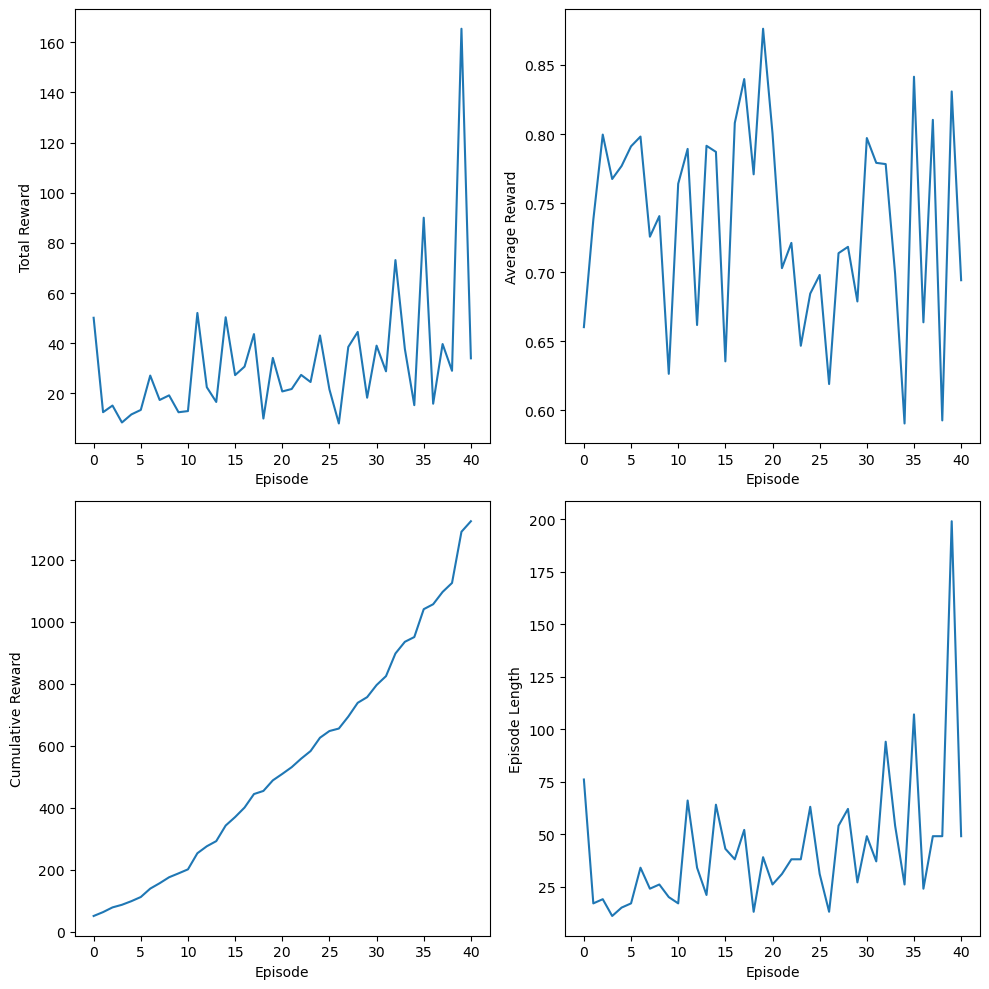

In [11]:
# ts = '2024.07.04-17.27'
# results = np.load(f'results_{ts}.npy', allow_pickle=True)
# total_rewards = results.item().get("Total Reward")
# average_rewards = results.item().get("Average Reward")
# episode_lengths = results.item().get("Episode Length")

fig, ax = plt.subplots(2, 2, figsize=(10, 10))

ax[0][0].set_xlabel('Episode')
ax[0][0].set_ylabel('Total Reward')
ax[0][0].plot(total_rewards)
# total_rewards_rolling = np.convolve(total_rewards, np.ones(len(total_rewards)//10), 'same') / (len(total_rewards)//10)
# ax[0][0].plot(total_rewards_rolling)

ax[0][1].set_xlabel('Episode')
ax[0][1].set_ylabel('Average Reward')
ax[0][1].plot(average_rewards)
# average_rewards_rolling = np.convolve(average_rewards, np.ones(len(average_rewards)//10), 'same') / (len(average_rewards)//10)
# ax[0][1].plot(average_rewards_rolling)

ax[1][0].set_xlabel('Episode')
ax[1][0].set_ylabel('Cumulative Reward')
cumulative_rewards = np.cumsum(total_rewards)
ax[1][0].plot(cumulative_rewards)

ax[1][1].set_xlabel('Episode')
ax[1][1].set_ylabel('Episode Length')
ax[1][1].plot(episode_lengths, label='Lengths')
# episode_lengths_rolling = np.convolve(episode_lengths, np.ones(len(episode_lengths)//10), 'same') / (len(episode_lengths)//10)
# ax[1][1].plot(episode_lengths_rolling, 'b--', label='Smoothed Lengths')
# ax[1][1].legend()

fig.tight_layout()
plt.show()

In [ ]:
import time
timestamp = time.strftime("%Y.%m.%d-%H.%M")
#np.save(f'total_reward_{timestamp}.npy', total_rewards)
#np.save(f'running_reward_{timestamp}.npy', running_rewards)
#np.save(f'average_reward_{timestamp}.npy', average_rewards)
results = {"Total Reward":total_rewards,
           "Cumulative Reward": np.cumsum(total_rewards),
           "Average Reward": average_rewards,
           "Episode Length": episode_lengths}
np.save(f'results_{timestamp}.npy', results)
agent.save(timestamp)

In [ ]:
# Play:
import matplotlib.animation as anim
import tensorflow_docs.vis.embed as embed

actor = keras.models.load_model(f"actor_{timestamp}.keras", compile=False)

env = gym.make('CartPole-v1')
observation = env.reset()

frames=[]
for i in range(500):
  frames.append(env.render(mode='rgb_array'))
  action = np.random.choice(env.action_space.n,
                                p=actor.predict(observation[np.newaxis, :],
                                                 verbose=False).flatten())
  observation, _, done, _ = env.step(action)
  if done:
      break

env.close()

def init():
    global im, text
    im = ax.imshow(frames[0])
    text = ax.text(.05, .95, '1', ha='left',
                   va='top', transform=ax.transAxes) 

def animate(i):
  global im, text
  im.set_data(frames[i])
  text.set_text(str(i))

fig = plt.figure()
ax = plt.gca()
ax.axis('off')

animation = anim.FuncAnimation(fig, animate, init_func=init, frames=500)
animation.save(f'animation_{timestamp}.gif', writer='ffmpeg', fps=30)
plt.close(fig)
embed.embed_file(f'animation_{timestamp}.gif')

In [ ]:
timestamp